In [1]:
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim import Adam
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = "/home/kusum/Desktop/Dataset A/Train"
test_path = "/home/kusum/Desktop/Dataset A/Test"

In [3]:
transformer = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
dataset = ImageFolder(train_path, transform = transformer)
len_ds = dataset.__len__()
print(len_ds)

3600


torch.Size([3, 512, 512])
0


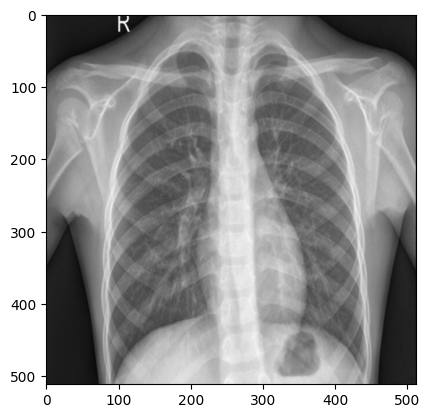

In [4]:
img, label = dataset[0]
print(img.shape)
print(label)
plt.imshow(img.permute(1,2,0))

In [4]:
classes = dataset.classes
num_classes = len(classes)
num_classes

2

In [5]:
from collections import Counter
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
print(img_dict) 

{'NORMAL': 0, 'PNEUMONIA': 0}


In [6]:
for i in range(len_ds):
    img, label = dataset[i]
    img_dict[classes[label]] += 1
img_dict  

{'NORMAL': 1000, 'PNEUMONIA': 2600}

In [7]:
k,m = img_dict.values()

<BarContainer object of 2 artists>

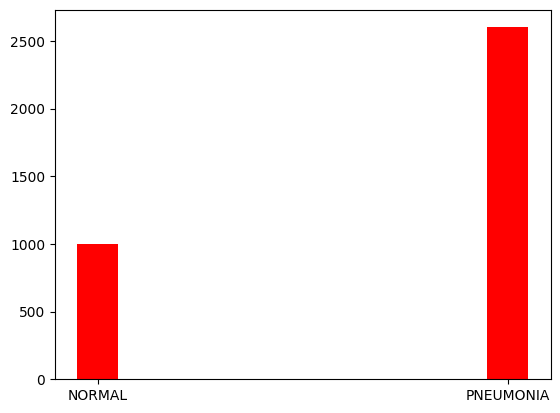

In [8]:
values = [k, m]
plt.bar(classes, values , width=0.10, color = 'r')

In [6]:
train_ds, val_ds = random_split(dataset, [3600, 0])

In [10]:
train_dict = {}
for i in range(num_classes):
    train_dict[classes[i]] = 0
print(train_dict)    
for i in range(len(train_ds)):
    img, label = train_ds[i]
    train_dict[classes[label]] += 1
train_dict 
class_count = []
print(train_dict.values())

{'NORMAL': 0, 'PNEUMONIA': 0}
dict_values([1000, 2600])


In [11]:
class_count = list(train_dict.values())
class_count

[1000, 2600]

In [12]:
import numpy as np 

y_train_indices = train_ds.indices

y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [13]:
class_count = np.asarray(class_count)

In [14]:
weight = 1. / class_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [15]:
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [16]:
# train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler, pin_memory=True)
test_ds = ImageFolder(test_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True, shuffle=True)
len_test = len(test_ds)

In [9]:
for img, label in train_dl:
    print(img.shape)
    print(len(label))
    break

NameError: name 'train_dl' is not defined

In [18]:
count0=0
count1=0
for i in range(len(label)):
    if (label[i] == 1):
        count1 += 1
    else:
        count0 +=1
print(count0, count1)   

13 19


In [19]:
len_train = len(train_ds)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
class cnn_sampler(nn.Module):
    def __init__(self):
        super(cnn_sampler, self).__init__()
        #shape=20, 3, 512, 512
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 16, 512, 512
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2))
        self.norm1 = nn.BatchNorm2d(16)
        #shape=20, 16, 256, 256

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 32, 256, 256
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2))
        #shape=20, 32, 128, 128        
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 64, 128, 128
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)
       
        
        self.fc1 = nn.Linear(in_features= 64*128*128, out_features=100)
        self.fc2 = nn.Linear(in_features= 100, out_features=2)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.norm1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)
    
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.drop(output)
        
      
        output = output.view(-1, 64*128*128)
        output = self.fc1(output)
        output = self.fc2(output)
       
        return output
        

In [11]:
torch.cuda.empty_cache()

In [12]:
model = cnn_sampler().to(device)
model

OutOfMemoryError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 11.77 GiB total capacity; 96.00 KiB already allocated; 268.25 MiB free; 2.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.0003, weight_decay = 0.001)

In [13]:
from time import time 
from tqdm import tqdm 

In [27]:
import logging
import torch
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='CNN_sampler_on_a.log', mode='a')
logger.addHandler(fhandler)

In [28]:
Train_accuracy = []
Train_loss = []
Test_loss = []
Test_accuracy = []
best_loss = 0
for epoch in range(90):
    train_acc = 0
    start1 = time()
    
    # Train
    model.train()
    
    with tqdm(train_dl, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimizer.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimizer.step()
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            #Train_loss.append(loss.item())
            train_acc += int(torch.sum(train_pred == ytrain))
           
           
        Train_loss.append(loss.item())    
        ep_tr_acc = train_acc / len_train
        Train_accuracy.append(ep_tr_acc)
    end1 = time()   
    
    #Model test-
    start2 = time()
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for xtest, ytest in test_dl:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_loss = loss_fn(test_prob, ytest)
            #Val_loss.append(test_loss.item())
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
        
            
        Test_loss.append(test_loss.item())   
        ep_test_acc = test_acc / len_test
        Test_accuracy.append(ep_test_acc)
  
    if(epoch % 8 == 0):
        torch.save(model.state_dict(), "Best_CNN_sampler_on_A" + str(epoch))
        
    end2 = time()
    duration1 = (end1 - start1) / 60
    duration2 = (end2 - start2) / 60

    print(f"Epoch: {epoch}, Time for one epoch for training: {duration1} \n Train_Loss: {loss}, Train_accuracy: {ep_tr_acc} \n Test_loss:{test_loss}, Test_accuracy:{ep_test_acc}, Test_duration:{duration2}")
    logging.warning(f"Epoch: {epoch}\n Time for one epoch: {duration1} \n Train_Loss: {loss}\n Train_accuracy: {ep_tr_acc}\n  Test_loss:{test_loss}\n Test_accuracy:{ep_test_acc}\n Test_duration:{duration2}")

100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 0, Time for one epoch for training: 0.9578082283337911 
 Train_Loss: 0.08546572178602219, Train_accuracy: 0.8755555555555555 
 Test_loss:0.029031941667199135, Test_accuracy:0.8144904458598726, Test_duration:0.25822527408599855


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 1, Time for one epoch for training: 0.9517279346783956 
 Train_Loss: 0.10039785504341125, Train_accuracy: 0.9772222222222222 
 Test_loss:0.056913793087005615, Test_accuracy:0.9036624203821656, Test_duration:0.2537219524383545


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 2, Time for one epoch for training: 0.9430296103159587 
 Train_Loss: 0.015409309417009354, Train_accuracy: 0.9902777777777778 
 Test_loss:1.7356330156326294, Test_accuracy:0.8590764331210191, Test_duration:0.25370462735493976


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 3, Time for one epoch for training: 0.9412100275357564 
 Train_Loss: 0.01618572138249874, Train_accuracy: 0.9930555555555556 
 Test_loss:1.2263768911361694, Test_accuracy:0.8168789808917197, Test_duration:0.2535676638285319


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 4, Time for one epoch for training: 0.9477924704551697 
 Train_Loss: 0.04260963946580887, Train_accuracy: 0.9963888888888889 
 Test_loss:1.4623380899429321, Test_accuracy:0.820859872611465, Test_duration:0.25326242446899416


100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch: 5, Time for one epoch for training: 0.9347242474555969 
 Train_Loss: 0.004568380769342184, Train_accuracy: 0.9966666666666667 
 Test_loss:0.00013134749315213412, Test_accuracy:0.820859872611465, Test_duration:0.25481738249460856


100%|██████████| 113/113 [00:55<00:00,  2.02batch/s]


Epoch: 6, Time for one epoch for training: 0.9315883795420329 
 Train_Loss: 0.01624310202896595, Train_accuracy: 0.9958333333333333 
 Test_loss:0.3997744917869568, Test_accuracy:0.9036624203821656, Test_duration:0.2535699844360352


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 7, Time for one epoch for training: 0.9482832471529643 
 Train_Loss: 0.047319117933511734, Train_accuracy: 0.9980555555555556 
 Test_loss:1.1980360746383667, Test_accuracy:0.8359872611464968, Test_duration:0.25650983651479087


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 8, Time for one epoch for training: 0.9509165445963542 
 Train_Loss: 0.0075222221203148365, Train_accuracy: 0.9955555555555555 
 Test_loss:0.0716293603181839, Test_accuracy:0.8694267515923567, Test_duration:0.260869840780894


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 9, Time for one epoch for training: 0.9443451960881551 
 Train_Loss: 0.005756044294685125, Train_accuracy: 0.9961111111111111 
 Test_loss:3.502227306365967, Test_accuracy:0.8909235668789809, Test_duration:0.25405997037887573


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 10, Time for one epoch for training: 0.9564499417940776 
 Train_Loss: 0.007100391201674938, Train_accuracy: 0.9947222222222222 
 Test_loss:0.0002603998000267893, Test_accuracy:0.8773885350318471, Test_duration:0.25100457668304443


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 11, Time for one epoch for training: 0.9457757512728373 
 Train_Loss: 0.0005003341939300299, Train_accuracy: 0.9913888888888889 
 Test_loss:1.4263293743133545, Test_accuracy:0.8097133757961783, Test_duration:0.2556937336921692


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 12, Time for one epoch for training: 0.9507664640744528 
 Train_Loss: 0.001519103767350316, Train_accuracy: 0.9927777777777778 
 Test_loss:0.001140482141636312, Test_accuracy:0.8734076433121019, Test_duration:0.25411216417948407


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 13, Time for one epoch for training: 0.9440534194310506 
 Train_Loss: 0.00046250957529991865, Train_accuracy: 0.9925 
 Test_loss:0.6566036939620972, Test_accuracy:0.892515923566879, Test_duration:0.26248098611831666


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 14, Time for one epoch for training: 0.9505783319473267 
 Train_Loss: 0.0011722465278580785, Train_accuracy: 0.9952777777777778 
 Test_loss:0.006977322977036238, Test_accuracy:0.8320063694267515, Test_duration:0.25528222719828286


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 15, Time for one epoch for training: 0.9415939966837565 
 Train_Loss: 0.024007804691791534, Train_accuracy: 0.9952777777777778 
 Test_loss:1.4442598819732666, Test_accuracy:0.7914012738853503, Test_duration:0.2532240907351176


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 16, Time for one epoch for training: 0.9409804662068685 
 Train_Loss: 0.0002844246628228575, Train_accuracy: 0.9977777777777778 
 Test_loss:0.2948676645755768, Test_accuracy:0.8654458598726115, Test_duration:0.26033734480539955


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 17, Time for one epoch for training: 0.943833863735199 
 Train_Loss: 0.0017062562983483076, Train_accuracy: 0.9991666666666666 
 Test_loss:0.03951045125722885, Test_accuracy:0.8765923566878981, Test_duration:0.2548767725626628


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 18, Time for one epoch for training: 0.955672558148702 
 Train_Loss: 0.001114461338147521, Train_accuracy: 0.9997222222222222 
 Test_loss:0.5798866152763367, Test_accuracy:0.8479299363057324, Test_duration:0.2548407236735026


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 19, Time for one epoch for training: 0.9554337342580159 
 Train_Loss: 0.04014069586992264, Train_accuracy: 0.9997222222222222 
 Test_loss:1.2665967688008095e-06, Test_accuracy:0.8320063694267515, Test_duration:0.2543641686439514


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 20, Time for one epoch for training: 0.959408696492513 
 Train_Loss: 0.007815230637788773, Train_accuracy: 0.985 
 Test_loss:0.6265534162521362, Test_accuracy:0.8765923566878981, Test_duration:0.25400638580322266


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 21, Time for one epoch for training: 0.9418608665466308 
 Train_Loss: 0.0012737740762531757, Train_accuracy: 0.9908333333333333 
 Test_loss:0.10072179138660431, Test_accuracy:0.8654458598726115, Test_duration:0.2529296080271403


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 22, Time for one epoch for training: 0.9412607590357462 
 Train_Loss: 0.002117957454174757, Train_accuracy: 0.9963888888888889 
 Test_loss:0.109856978058815, Test_accuracy:0.8598726114649682, Test_duration:0.25320168733596804


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 23, Time for one epoch for training: 0.9538254817326863 
 Train_Loss: 0.0031581949442625046, Train_accuracy: 0.9972222222222222 
 Test_loss:0.4657430648803711, Test_accuracy:0.8558917197452229, Test_duration:0.25474197467168175


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 24, Time for one epoch for training: 0.9585181037584941 
 Train_Loss: 0.0018448150949552655, Train_accuracy: 0.9986111111111111 
 Test_loss:0.9242914915084839, Test_accuracy:0.821656050955414, Test_duration:0.2599250634511312


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 25, Time for one epoch for training: 0.942812963326772 
 Train_Loss: 0.0007186317234300077, Train_accuracy: 0.9938888888888889 
 Test_loss:0.5125977396965027, Test_accuracy:0.8757961783439491, Test_duration:0.2560229738553365


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 26, Time for one epoch for training: 0.9575199683507284 
 Train_Loss: 0.030818236991763115, Train_accuracy: 0.9905555555555555 
 Test_loss:0.027753610163927078, Test_accuracy:0.8941082802547771, Test_duration:0.2549241542816162


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 27, Time for one epoch for training: 0.9627091288566589 
 Train_Loss: 0.0094450069591403, Train_accuracy: 0.9966666666666667 
 Test_loss:6.359723920468241e-05, Test_accuracy:0.8678343949044586, Test_duration:0.2540850798288981


100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch: 28, Time for one epoch for training: 0.9388838489850362 
 Train_Loss: 0.0005034501664340496, Train_accuracy: 0.9977777777777778 
 Test_loss:0.009656457230448723, Test_accuracy:0.8646496815286624, Test_duration:0.25519633293151855


100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch: 29, Time for one epoch for training: 0.9373931368192037 
 Train_Loss: 0.0017618383280932903, Train_accuracy: 0.9977777777777778 
 Test_loss:1.411045789718628, Test_accuracy:0.8646496815286624, Test_duration:0.2546173254648844


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 30, Time for one epoch for training: 0.9576957941055297 
 Train_Loss: 0.0023202397860586643, Train_accuracy: 0.9963888888888889 
 Test_loss:1.5351474285125732, Test_accuracy:0.8590764331210191, Test_duration:0.25674484570821127


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 31, Time for one epoch for training: 0.9410605152448018 
 Train_Loss: 0.013929127715528011, Train_accuracy: 0.9947222222222222 
 Test_loss:0.07951490581035614, Test_accuracy:0.8702229299363057, Test_duration:0.25356711546579996


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 32, Time for one epoch for training: 0.9509685595830282 
 Train_Loss: 9.034498361870646e-05, Train_accuracy: 0.9986111111111111 
 Test_loss:0.3060007095336914, Test_accuracy:0.8535031847133758, Test_duration:0.2600571632385254


100%|██████████| 113/113 [00:59<00:00,  1.91batch/s]


Epoch: 33, Time for one epoch for training: 0.9854743480682373 
 Train_Loss: 0.0002950727939605713, Train_accuracy: 0.9975 
 Test_loss:0.7072467803955078, Test_accuracy:0.8351910828025477, Test_duration:0.26057424147923786


100%|██████████| 113/113 [00:58<00:00,  1.95batch/s]


Epoch: 34, Time for one epoch for training: 0.9673246741294861 
 Train_Loss: 0.000652406713925302, Train_accuracy: 0.9958333333333333 
 Test_loss:1.534711241722107, Test_accuracy:0.820859872611465, Test_duration:0.2534861445426941


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 35, Time for one epoch for training: 0.9454332709312439 
 Train_Loss: 0.0028345065657049417, Train_accuracy: 0.9927777777777778 
 Test_loss:0.16919051110744476, Test_accuracy:0.8558917197452229, Test_duration:0.25285550355911257


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 36, Time for one epoch for training: 0.9605924725532532 
 Train_Loss: 0.024848084896802902, Train_accuracy: 0.9891666666666666 
 Test_loss:2.3543725546915084e-06, Test_accuracy:0.8590764331210191, Test_duration:0.2544187903404236


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 37, Time for one epoch for training: 0.9535003741582234 
 Train_Loss: 0.003779070684686303, Train_accuracy: 0.9952777777777778 
 Test_loss:1.1213932037353516, Test_accuracy:0.8805732484076433, Test_duration:0.2547179063161214


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 38, Time for one epoch for training: 0.9589109857877095 
 Train_Loss: 0.0020296992734074593, Train_accuracy: 0.9958333333333333 
 Test_loss:0.0005086004384793341, Test_accuracy:0.8893312101910829, Test_duration:0.2605605522791545


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 39, Time for one epoch for training: 0.9437381307284037 
 Train_Loss: 0.00032535826903767884, Train_accuracy: 0.9966666666666667 
 Test_loss:0.03869905322790146, Test_accuracy:0.875, Test_duration:0.2503204862276713


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 40, Time for one epoch for training: 0.9567042708396911 
 Train_Loss: 0.0053919898346066475, Train_accuracy: 0.9983333333333333 
 Test_loss:0.64628005027771, Test_accuracy:0.8980891719745223, Test_duration:0.25841966867446897


100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch: 41, Time for one epoch for training: 0.935668432712555 
 Train_Loss: 0.008010592311620712, Train_accuracy: 0.9991666666666666 
 Test_loss:1.3606693744659424, Test_accuracy:0.8590764331210191, Test_duration:0.2526513655980428


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 42, Time for one epoch for training: 0.9527765035629272 
 Train_Loss: 2.894973113143351e-05, Train_accuracy: 0.9991666666666666 
 Test_loss:2.929743528366089, Test_accuracy:0.8503184713375797, Test_duration:0.25414086182912193


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 43, Time for one epoch for training: 0.9447655439376831 
 Train_Loss: 0.00047260901192203164, Train_accuracy: 0.995 
 Test_loss:0.7243209481239319, Test_accuracy:0.8726114649681529, Test_duration:0.2551898678143819


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 44, Time for one epoch for training: 0.952475126584371 
 Train_Loss: 0.04070654511451721, Train_accuracy: 0.9952777777777778 
 Test_loss:0.0028843642212450504, Test_accuracy:0.8710191082802548, Test_duration:0.2571628967920939


100%|██████████| 113/113 [00:56<00:00,  1.98batch/s]


Epoch: 45, Time for one epoch for training: 0.9498329520225525 
 Train_Loss: 0.014122179709374905, Train_accuracy: 0.995 
 Test_loss:0.165644109249115, Test_accuracy:0.893312101910828, Test_duration:0.25389941533406574


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 46, Time for one epoch for training: 0.9458306074142456 
 Train_Loss: 0.004802175797522068, Train_accuracy: 0.9941666666666666 
 Test_loss:0.022599373012781143, Test_accuracy:0.8734076433121019, Test_duration:0.25284817616144817


100%|██████████| 113/113 [00:57<00:00,  1.95batch/s]


Epoch: 47, Time for one epoch for training: 0.9645403544108073 
 Train_Loss: 0.0008413983741775155, Train_accuracy: 0.9958333333333333 
 Test_loss:0.0002196521236328408, Test_accuracy:0.8407643312101911, Test_duration:0.2545552412668864


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 48, Time for one epoch for training: 0.9544112682342529 
 Train_Loss: 0.00020501873223111033, Train_accuracy: 0.9983333333333333 
 Test_loss:0.4741779863834381, Test_accuracy:0.8535031847133758, Test_duration:0.2679887771606445


100%|██████████| 113/113 [00:56<00:00,  1.98batch/s]


Epoch: 49, Time for one epoch for training: 0.9489051183064778 
 Train_Loss: 0.06705991923809052, Train_accuracy: 0.9947222222222222 
 Test_loss:0.5852392911911011, Test_accuracy:0.8861464968152867, Test_duration:0.2555888573328654


100%|██████████| 113/113 [00:56<00:00,  1.98batch/s]


Epoch: 50, Time for one epoch for training: 0.9488183736801148 
 Train_Loss: 0.008281631395220757, Train_accuracy: 0.9975 
 Test_loss:0.6189833879470825, Test_accuracy:0.8471337579617835, Test_duration:0.2620130936304728


100%|██████████| 113/113 [00:57<00:00,  1.95batch/s]


Epoch: 51, Time for one epoch for training: 0.9640259583791096 
 Train_Loss: 9.726319694891572e-05, Train_accuracy: 1.0 
 Test_loss:0.436178594827652, Test_accuracy:0.8757961783439491, Test_duration:0.25672587553660076


100%|██████████| 113/113 [00:56<00:00,  1.98batch/s]


Epoch: 52, Time for one epoch for training: 0.9488860170046488 
 Train_Loss: 0.003417167579755187, Train_accuracy: 0.9963888888888889 
 Test_loss:1.6230846643447876, Test_accuracy:0.8359872611464968, Test_duration:0.2622625509897868


100%|██████████| 113/113 [00:57<00:00,  1.95batch/s]


Epoch: 53, Time for one epoch for training: 0.9647236227989197 
 Train_Loss: 0.0007460277993232012, Train_accuracy: 0.9966666666666667 
 Test_loss:11.933062553405762, Test_accuracy:0.8264331210191083, Test_duration:0.25098830461502075


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 54, Time for one epoch for training: 0.9480902870496114 
 Train_Loss: 0.00016579983639530838, Train_accuracy: 0.9916666666666667 
 Test_loss:2.267169713973999, Test_accuracy:0.8471337579617835, Test_duration:0.25772852500279747


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 55, Time for one epoch for training: 0.9469958345095316 
 Train_Loss: 0.0005762766231782734, Train_accuracy: 0.9969444444444444 
 Test_loss:5.321897029876709, Test_accuracy:0.8694267515923567, Test_duration:0.24845642646153768


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 56, Time for one epoch for training: 0.962369155883789 
 Train_Loss: 0.011356694623827934, Train_accuracy: 0.9902777777777778 
 Test_loss:0.06773960590362549, Test_accuracy:0.8662420382165605, Test_duration:0.25426847537358604


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 57, Time for one epoch for training: 0.9427128354708354 
 Train_Loss: 0.002411142224445939, Train_accuracy: 0.9991666666666666 
 Test_loss:0.023517748340964317, Test_accuracy:0.8646496815286624, Test_duration:0.248242457707723


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 58, Time for one epoch for training: 0.9528839151064555 
 Train_Loss: 0.0006184568046592176, Train_accuracy: 0.9983333333333333 
 Test_loss:2.5067312717437744, Test_accuracy:0.8519108280254777, Test_duration:0.2479324738184611


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 59, Time for one epoch for training: 0.947832711537679 
 Train_Loss: 0.01353909820318222, Train_accuracy: 0.9941666666666666 
 Test_loss:0.820197582244873, Test_accuracy:0.8479299363057324, Test_duration:0.24862490892410277


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 60, Time for one epoch for training: 0.9469160358111064 
 Train_Loss: 0.008264962583780289, Train_accuracy: 0.9975 
 Test_loss:1.6836787462234497, Test_accuracy:0.8527070063694268, Test_duration:0.2502379179000854


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 61, Time for one epoch for training: 0.9541348139444987 
 Train_Loss: 0.0023058021906763315, Train_accuracy: 0.9994444444444445 
 Test_loss:1.4459000825881958, Test_accuracy:0.8495222929936306, Test_duration:0.24958751598993936


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 62, Time for one epoch for training: 0.9550805568695069 
 Train_Loss: 0.001194637967273593, Train_accuracy: 0.9980555555555556 
 Test_loss:0.7465646266937256, Test_accuracy:0.8630573248407644, Test_duration:0.24799666404724122


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 63, Time for one epoch for training: 0.947747015953064 
 Train_Loss: 0.5675588846206665, Train_accuracy: 0.9977777777777778 
 Test_loss:0.44727733731269836, Test_accuracy:0.85828025477707, Test_duration:0.25616520245869956


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 64, Time for one epoch for training: 0.9412811597188314 
 Train_Loss: 4.468111728783697e-05, Train_accuracy: 0.9961111111111111 
 Test_loss:0.000889391521923244, Test_accuracy:0.8558917197452229, Test_duration:0.2539254387219747


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 65, Time for one epoch for training: 0.9584442218144734 
 Train_Loss: 0.005906315520405769, Train_accuracy: 0.9983333333333333 
 Test_loss:2.1551103591918945, Test_accuracy:0.8670382165605095, Test_duration:0.24862184524536132


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 66, Time for one epoch for training: 0.9628467043240865 
 Train_Loss: 4.360586535767652e-05, Train_accuracy: 0.9994444444444445 
 Test_loss:1.3641657829284668, Test_accuracy:0.8742038216560509, Test_duration:0.2626945416132609


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 67, Time for one epoch for training: 0.9477131525675456 
 Train_Loss: 0.04550817236304283, Train_accuracy: 0.9983333333333333 
 Test_loss:1.8302861452102661, Test_accuracy:0.8535031847133758, Test_duration:0.24840203126271565


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 68, Time for one epoch for training: 0.9536832213401795 
 Train_Loss: 9.96267917798832e-05, Train_accuracy: 0.9977777777777778 
 Test_loss:0.4328092634677887, Test_accuracy:0.8519108280254777, Test_duration:0.2478181838989258


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 69, Time for one epoch for training: 0.9536637783050537 
 Train_Loss: 0.025545474141836166, Train_accuracy: 0.9980555555555556 
 Test_loss:7.656989097595215, Test_accuracy:0.820859872611465, Test_duration:0.2476324478785197


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 70, Time for one epoch for training: 0.9631587107976277 
 Train_Loss: 0.0006395490490831435, Train_accuracy: 0.9988888888888889 
 Test_loss:0.0021076533012092113, Test_accuracy:0.8423566878980892, Test_duration:0.24792340596516926


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 71, Time for one epoch for training: 0.953224257628123 
 Train_Loss: 0.00333635276183486, Train_accuracy: 0.9991666666666666 
 Test_loss:1.782435417175293, Test_accuracy:0.8726114649681529, Test_duration:0.24745696385701496


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 72, Time for one epoch for training: 0.9445865551630656 
 Train_Loss: 2.6773397621582262e-05, Train_accuracy: 0.9963888888888889 
 Test_loss:0.0676618441939354, Test_accuracy:0.8765923566878981, Test_duration:0.2546338438987732


100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch: 73, Time for one epoch for training: 0.9572690804799397 
 Train_Loss: 0.0006355862133204937, Train_accuracy: 0.9977777777777778 
 Test_loss:5.594515800476074, Test_accuracy:0.8248407643312102, Test_duration:0.24924445152282715


100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch: 74, Time for one epoch for training: 0.9353961785634358 
 Train_Loss: 0.00818630587309599, Train_accuracy: 0.9988888888888889 
 Test_loss:1.7601901292800903, Test_accuracy:0.8105095541401274, Test_duration:0.24784062306086221


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 75, Time for one epoch for training: 0.9586495677630107 
 Train_Loss: 5.267495907901321e-06, Train_accuracy: 0.9991666666666666 
 Test_loss:0.09113948047161102, Test_accuracy:0.8726114649681529, Test_duration:0.24865502913792928


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 76, Time for one epoch for training: 0.9475506703058879 
 Train_Loss: 0.00031651215977035463, Train_accuracy: 0.9994444444444445 
 Test_loss:1.4640179872512817, Test_accuracy:0.856687898089172, Test_duration:0.24904085397720338


100%|██████████| 113/113 [00:57<00:00,  1.98batch/s]


Epoch: 77, Time for one epoch for training: 0.9517802794774374 
 Train_Loss: 4.828373857890256e-05, Train_accuracy: 1.0 
 Test_loss:1.0523353815078735, Test_accuracy:0.8527070063694268, Test_duration:0.24761232137680053


100%|██████████| 113/113 [00:56<00:00,  2.02batch/s]


Epoch: 78, Time for one epoch for training: 0.9341307123502095 
 Train_Loss: 0.00019699583936017007, Train_accuracy: 0.9997222222222222 
 Test_loss:0.04765411466360092, Test_accuracy:0.8638535031847133, Test_duration:0.2478730837504069


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 79, Time for one epoch for training: 0.9441260496775309 
 Train_Loss: 0.5577138066291809, Train_accuracy: 0.9980555555555556 
 Test_loss:0.9440526366233826, Test_accuracy:0.8821656050955414, Test_duration:0.2502470413843791


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 80, Time for one epoch for training: 0.9482998212178548 
 Train_Loss: 0.4423488974571228, Train_accuracy: 0.9933333333333333 
 Test_loss:2.542858839035034, Test_accuracy:0.8726114649681529, Test_duration:0.2522882342338562


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 81, Time for one epoch for training: 0.946608301003774 
 Train_Loss: 3.6656260817835573e-06, Train_accuracy: 0.9977777777777778 
 Test_loss:0.0002483087591826916, Test_accuracy:0.8837579617834395, Test_duration:0.2486120621363322


100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch: 82, Time for one epoch for training: 0.9373006065686543 
 Train_Loss: 0.003292903769761324, Train_accuracy: 0.9991666666666666 
 Test_loss:1.0427346229553223, Test_accuracy:0.8200636942675159, Test_duration:0.248166024684906


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 83, Time for one epoch for training: 0.9591387391090394 
 Train_Loss: 0.006161903962492943, Train_accuracy: 0.9997222222222222 
 Test_loss:0.08203070610761642, Test_accuracy:0.8742038216560509, Test_duration:0.2484611948331197


100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch: 84, Time for one epoch for training: 0.9394888957341512 
 Train_Loss: 2.696046431083232e-05, Train_accuracy: 0.9994444444444445 
 Test_loss:1.5938193798065186, Test_accuracy:0.8710191082802548, Test_duration:0.2483086347579956


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 85, Time for one epoch for training: 0.9448692123095195 
 Train_Loss: 0.0008718215976841748, Train_accuracy: 1.0 
 Test_loss:0.6924078464508057, Test_accuracy:0.8757961783439491, Test_duration:0.24834961891174318


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 86, Time for one epoch for training: 0.9453777352968852 
 Train_Loss: 0.0001497542834840715, Train_accuracy: 1.0 
 Test_loss:0.7130657434463501, Test_accuracy:0.8734076433121019, Test_duration:0.24847565491994222


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 87, Time for one epoch for training: 0.9614851156870524 
 Train_Loss: 0.005999063607305288, Train_accuracy: 0.9986111111111111 
 Test_loss:1.1432170867919922, Test_accuracy:0.8662420382165605, Test_duration:0.24744359652201334


100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch: 88, Time for one epoch for training: 0.947372555732727 
 Train_Loss: 0.001046028221026063, Train_accuracy: 0.9991666666666666 
 Test_loss:0.20918245613574982, Test_accuracy:0.8463375796178344, Test_duration:0.2530196785926819


100%|██████████| 113/113 [00:57<00:00,  1.96batch/s]


Epoch: 89, Time for one epoch for training: 0.9587973594665528 
 Train_Loss: 2.569538446550723e-05, Train_accuracy: 1.0 
 Test_loss:0.1417216807603836, Test_accuracy:0.8638535031847133, Test_duration:0.24749747117360432


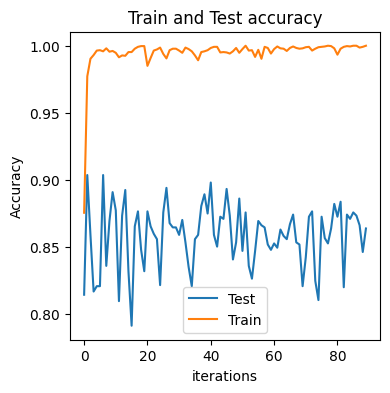

In [29]:
plt.figure(figsize=(4,4))
plt.title("Train and Test accuracy")
plt.plot(Test_accuracy,label="Test")
plt.plot(Train_accuracy,label="Train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

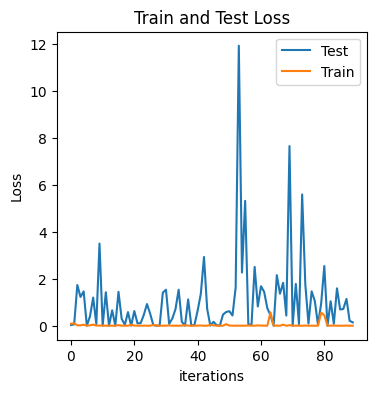

In [30]:
plt.figure(figsize=(4,4))
plt.title("Train and Test Loss")
plt.plot(Test_loss,label="Test")
plt.plot(Train_loss,label="Train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
print("Mean Train accuracy", (sum(Train_accuracy)/len(Train_accuracy)))
print("Mean Test accuracy", (sum(Test_accuracy)/len(Test_accuracy)))
print("Mean Train loss", (sum(Train_loss)/len(Train_loss)))
print("Mean Test loss", (sum(Test_loss)/len(Test_loss)))

Mean Train accuracy 0.9950246913580248
Mean Test accuracy 0.8584394904458601
Mean Train loss 0.026671129080705215
Mean Test loss 1.0563781885320458


# Best model evaluation-

In [14]:
checkpoint = torch.load("Best_CNN_sampler_on_A40")
model = cnn_sampler().to(device)
model.load_state_dict(checkpoint)
model.eval()

cnn_sampler(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [17]:
from time import time
pred_l = np.array([])
target = np.array([])
accuracy = np.array([])
model.eval()

for batch in test_dl:
    acc = 0
    start = time()
    x_test, y_test = batch
    x_test = x_test.to(device)
    prob = model(x_test)
    pred = torch.max(prob,1).indices
    pred = pred.cpu()
    acc += int(torch.sum(pred == y_test))

    accuracy = np.append(accuracy, acc/len(y_test))
    pred = pred.cpu().data.numpy()
    y_test = y_test.data.numpy()
    pred_l=np.append(pred_l, pred)
    target=np.append(target, y_test)
    end = time()
    Test_duration = (end - start)

print("Time taken for Testing", Test_duration)

Time taken for Testing 0.009798526763916016


In [18]:
accuracy

array([0.90625, 0.90625, 0.9375 , 0.90625, 0.84375, 0.9375 , 0.875  ,
       0.9375 , 0.875  , 0.90625, 0.875  , 0.875  , 0.9375 , 0.875  ,
       0.875  , 0.84375, 0.875  , 0.875  , 0.875  , 0.8125 , 0.90625,
       0.9375 , 0.90625, 0.84375, 0.875  , 0.9375 , 0.9375 , 0.875  ,
       0.84375, 0.90625, 0.84375, 0.96875, 0.875  , 0.96875, 0.9375 ,
       0.9375 , 0.875  , 1.     , 0.875  , 1.     ])

In [19]:
print(np.mean(accuracy))

0.9


In [19]:
from sklearn.metrics import classification_report
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(target, pred_l, target_names=target_names))

              precision    recall  f1-score   support

      NORMAL       0.94      0.82      0.88       571
   PNEUMONIA       0.87      0.96      0.91       685

    accuracy                           0.90      1256
   macro avg       0.91      0.89      0.90      1256
weighted avg       0.90      0.90      0.90      1256



In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, pred_l)
print(cm)

[[471 100]
 [ 28 657]]


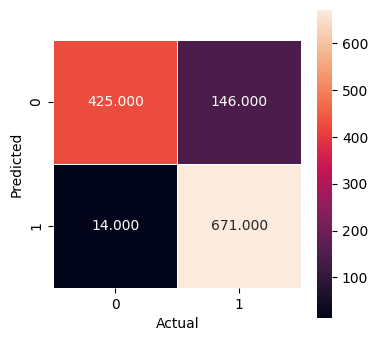

In [21]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(figsize = (4,4))
sb.heatmap(cm, annot=True, fmt="0.3f", linewidths=0.5, square=True, cbar=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

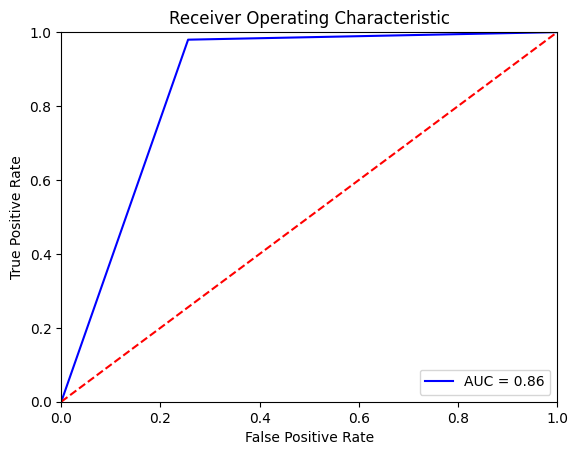

In [22]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(target, pred_l)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature Visualization-

In [20]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [21]:
model_children

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Dropout2d(p=0.2, inplace=False),
 Linear(in_features=1048576, out_features=100, bias=True),
 Linear(in_features=100, out_features=2, bias=True)]

In [22]:
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 3


In [25]:
image, label = dataset[0]
print(image.shape)
print(label)

torch.Size([3, 512, 512])
0


In [26]:
image = image.unsqueeze(0)
print(image.shape)
image = image.to(device)

torch.Size([1, 3, 512, 512])


In [27]:
# pass the image through all the layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([16, 512, 512])


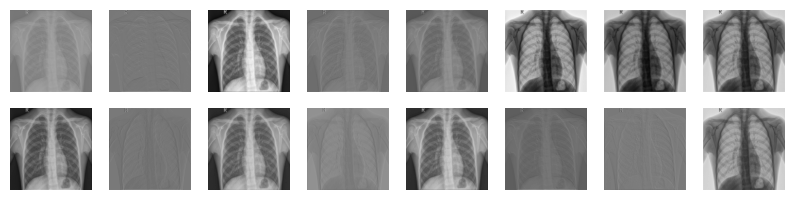

torch.Size([32, 512, 512])


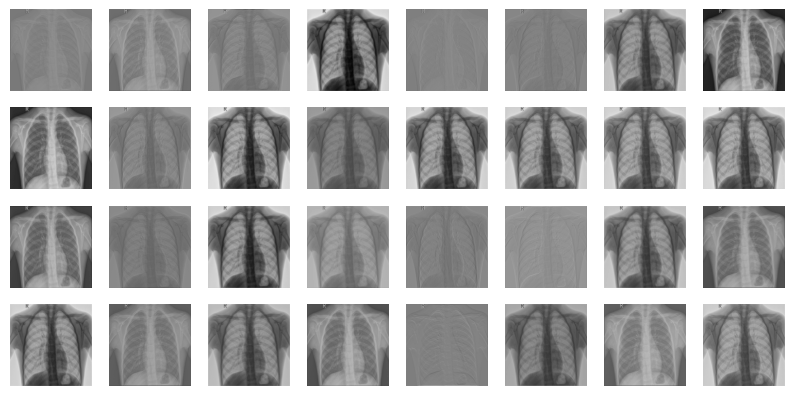

torch.Size([64, 512, 512])


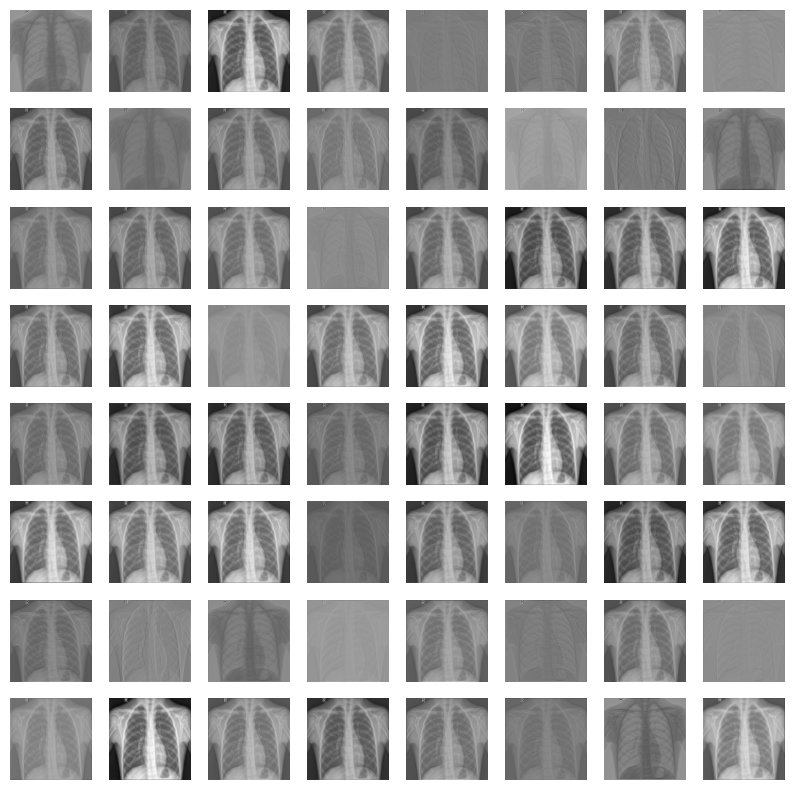

In [28]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(10,10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
#     print(f"Saving layer {num_layer} feature maps...")
#     plt.savefig(/home/kusum/Dekstop/Feature_map/ + str{num_layer} +".png")
    plt.show()
    plt.close()